In [81]:
# GDELT H5N1/Avian Flu Query Tutorial - Part 1: Setup and Querying
# ====================================================================

"""
GDELT (Global Database of Events, Language, and Tone) is a massive database
that monitors news media from around the world in over 100 languages. It
identifies events, locations, themes, emotions, and other information from
news articles.

In this tutorial, we'll query GDELT for mentions of H5N1/avian flu from
January 1, 2022 to January 1, 2025.
"""

# Step 1: Install Required Libraries
# -----------------------------------
# You'll need to run these in your terminal/command prompt:
# pip install pandas requests matplotlib seaborn

import pandas as pd
import requests
from datetime import datetime, timedelta
import time
import warnings
warnings.filterwarnings('ignore')

In [82]:
# Step 2: Understanding GDELT GKG (Global Knowledge Graph) API
# -------------------------------------------------------------
"""
GDELT has several datasets. We'll use the GKG (Global Knowledge Graph) which
contains:
- Themes: Topics mentioned in articles
- Locations: Geographic references
- Persons: People mentioned
- Organizations: Organizations mentioned
- Tone: Emotional tone of the article

The GKG API endpoint is:
https://api.gdeltproject.org/api/v2/doc/doc
"""

# Step 3: Define Search Parameters
# ---------------------------------
print("Step 3: Setting up search parameters...")

# Date range
start_date = "2022-06-01"
end_date = "2025-01-01"

# Search terms for H5N1 and avian flu
# We'll search for multiple related terms to capture all relevant articles
search_terms = [
    "H5N1",
    "avian flu",
    "bird flu",
    "avian influenza"
]

# Combine search terms with OR operator
# search_query = " OR ".join([f'"{term}"' for term in search_terms])
search_query = "H5N1"
print(f"Search query: {search_query}")

Step 3: Setting up search parameters...
Search query: H5N1


In [83]:
# Step 4: Build the GDELT Query URL
# ----------------------------------
print("\nStep 4: Building GDELT query URL...")

"""
Key parameters for GDELT API:
- query: The search terms
- mode: We'll use "ArtList" to get article-level data
- format: "json" for structured data
- maxrecords: Maximum number of records (max is 250 per request)
- startdatetime: Start date in YYYYMMDDHHMMSS format
- enddatetime: End date in YYYYMMDDHHMMSS format
"""

# Convert dates to GDELT format (YYYYMMDDHHMMSS)
start_dt = start_date.replace("-", "") + "000000"
end_dt = end_date.replace("-", "") + "000000"

# Build the base URL
base_url = "https://api.gdeltproject.org/api/v2/doc/doc"

# Build query parameters
params = {
    "query": search_query,
    "mode": "ArtList",
    "format": "json",
    "maxrecords": "250",
    "startdatetime": start_dt,
    "enddatetime": end_dt
}

print(f"Date range: {start_date} to {end_date}")
print(f"Requesting up to {params['maxrecords']} records")


Step 4: Building GDELT query URL...
Date range: 2022-06-01 to 2025-01-01
Requesting up to 250 records


In [84]:
# Step 5: Make the API Request
# -----------------------------
print("\nStep 5: Querying GDELT API...")

try:
    # Make the GET request
    response = requests.get(base_url, params=params, timeout=30)

    # Check if request was successful
    if response.status_code == 200:
        print("✓ Successfully retrieved data from GDELT")

        # Parse JSON response
        data = response.json()

        # Check if we got articles
        if 'articles' in data and len(data['articles']) > 0:
            print(f"✓ Retrieved {len(data['articles'])} articles")

            # Convert to DataFrame
            df = pd.DataFrame(data['articles'])
            print(f"✓ Created DataFrame with {len(df)} rows and {len(df.columns)} columns")

        else:
            print("⚠ No articles found in the response")
            df = pd.DataFrame()
    else:
        print(f"✗ Error: Received status code {response.status_code}")
        df = pd.DataFrame()

except Exception as e:
    print(f"✗ Error occurred: {str(e)}")
    df = pd.DataFrame()


Step 5: Querying GDELT API...
✓ Successfully retrieved data from GDELT
✓ Retrieved 250 articles
✓ Created DataFrame with 250 rows and 8 columns


In [85]:

# Step 6: Examine the Raw Data
# -----------------------------
print("\nStep 6: Examining the retrieved data...")

if not df.empty:
    print(f"\nDataFrame shape: {df.shape}")
    print(f"\nColumn names:")
    for col in df.columns:
        print(f"  - {col}")

    print(f"\nFirst few rows:")
    print(df.head(2))

    # Save raw data to CSV
    df.to_csv('gdelt_h5n1_raw.csv', index=False)
    print("\n✓ Raw data saved to 'gdelt_h5n1_raw.csv'")
else:
    print("\n⚠ No data to examine")

print("\n" + "="*70)
print("Part 1 Complete! Next: Data cleaning and preparation")
print("="*70)


Step 6: Examining the retrieved data...

DataFrame shape: (250, 8)

Column names:
  - url
  - url_mobile
  - title
  - seendate
  - socialimage
  - domain
  - language
  - sourcecountry

First few rows:
                                                 url url_mobile  \
0  https://www.newsweek.com/bird-flu-update-poult...              
1  https://www.theepochtimes.com/us/missouri-bird...              

                                               title          seendate  \
0  Bird Flu united states Update as Virus Suspect...  20241022T160000Z   
1  Missouri Bird Flu Investigation Finds No Evide...  20241024T233000Z   

                                         socialimage             domain  \
0  https://d.newsweek.com/en/full/2501351/bird-fl...       newsweek.com   
1  https://img.theepochtimes.com/assets/uploads/2...  theepochtimes.com   

  language  sourcecountry  
0  English  United States  
1  English  United States  

✓ Raw data saved to 'gdelt_h5n1_raw.csv'

Part 1 Complete! N

In [86]:
# GDELT H5N1/Avian Flu Query Tutorial - Part 2: Data Cleaning and Preparation
# =============================================================================

"""
In this part, we'll clean and prepare the GDELT data for analysis. We'll:
1. Parse dates properly
2. Handle missing values
3. Create derived features for analysis
"""

import pandas as pd
import numpy as np
from datetime import datetime

# Load the data from Part 1
# (In practice, you'd continue from the previous script)
print("Loading data from Part 1...")
df = pd.read_csv('gdelt_h5n1_raw.csv')
print(f"Loaded {len(df)} articles\n")

Loading data from Part 1...
Loaded 250 articles



In [104]:
# Step 1: Examine Key Columns
# ----------------------------
print("Step 1: Examining key columns...")

"""
Important GDELT columns include:
- url: The article URL
- domain: The news domain (e.g., cnn.com)
- seendate: When GDELT first saw the article (YYYYMMDDTHHMMSSZ format)
- title: Article title
- language: Language of the article
- tone: Comma-separated values with tone metrics
"""

# Reload the data to ensure 'seendate' is present
try:
    df = pd.read_csv('gdelt_h5n1_raw.csv')
    print("✓ Reloaded data from 'gdelt_h5n1_raw.csv'")
except FileNotFoundError:
    print("✗ Error: 'gdelt_h5n1_raw.csv' not found. Please run the previous steps to generate it.")
    df = pd.DataFrame() # Create an empty DataFrame to avoid further errors


if not df.empty:
    print("Key columns available:")
    key_cols = ['url', 'domain', 'seendate', 'title', 'language']
    for col in key_cols:
        if col in df.columns:
            print(f"  ✓ {col}")
            # Show example
            if not df[col].isna().all():
                example = df[col].dropna().iloc[0]
                print(f"    Example: {str(example)[:100]}...")
        else:
            print(f"  ✗ {col} (not found)")

    # Step 2: Parse Dates
    # -------------------
    print("\n" + "="*70)
    print("Step 2: Parsing dates...")

    """
    GDELT dates are in format: YYYYMMDDTHHMMSSZ
    Example: 20220115T120000Z means January 15, 2022 at 12:00:00 UTC
    """

    # Convert seendate to datetime
    df['date'] = pd.to_datetime(df['seendate'], format='%Y%m%dT%H%M%SZ', errors='coerce')

    # Extract useful date components
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['year_month'] = df['date'].dt.to_period('M')
    df['week'] = df['date'].dt.to_period('W')
    # Extract day of the week
    df['day_of_week'] = df['date'].dt.day_name()


    print(f"✓ Parsed dates successfully")
    print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"  Articles by year:")
    print(df['year'].value_counts().sort_index())
else:
    print("\n✗ Cannot proceed with date parsing as DataFrame is empty.")

Step 1: Examining key columns...
✓ Reloaded data from 'gdelt_h5n1_raw.csv'
Key columns available:
  ✓ url
    Example: https://www.newsweek.com/bird-flu-update-poultry-farm-workers-test-positive-h5n1-virus-washington-19...
  ✓ domain
    Example: newsweek.com...
  ✓ seendate
    Example: 20241022T160000Z...
  ✓ title
    Example: Bird Flu united states Update as Virus Suspected in Four Washington Farmers...
  ✓ language
    Example: English...

Step 2: Parsing dates...
✓ Parsed dates successfully
  Date range: 2024-10-03 02:15:00 to 2025-01-01 03:45:00
  Articles by year:
year
2024    249
2025      1
Name: count, dtype: int64


In [105]:
# Step 4: Clean Text Fields
# --------------------------
print("\n" + "="*70)
print("Step 4: Cleaning text fields...")

# Clean title field
if 'title' in df.columns:
    # Remove extra whitespace
    df['title_clean'] = df['title'].str.strip()
    # Calculate title length
    df['title_length'] = df['title_clean'].str.len()

    print("✓ Cleaned titles")
    print(f"  Average title length: {df['title_length'].mean():.0f} characters")
    print(f"  Median title length: {df['title_length'].median():.0f} characters")



Step 4: Cleaning text fields...
✓ Cleaned titles
  Average title length: 71 characters
  Median title length: 68 characters


In [106]:
# Step 5: Analyze Domains
# ------------------------
print("\n" + "="*70)
print("Step 5: Analyzing domains...")

# Extract domain type (e.g., news, health, government)
def classify_domain(domain):
    """Classify domain into broad categories"""
    if pd.isna(domain):
        return 'Unknown'

    domain = str(domain).lower()

    # Government and health authorities
    if any(x in domain for x in ['.gov', '.mil', 'cdc.', 'who.int', 'nih.gov']):
        return 'Government/Health Authority'

    # Academic and research
    elif any(x in domain for x in ['.edu', 'scholar', 'pubmed', 'sciencedirect']):
        return 'Academic/Research'

    # Major news outlets
    elif any(x in domain for x in ['cnn.', 'bbc.', 'reuters.', 'ap.org', 'nytimes.',
                                     'washingtonpost.', 'theguardian.', 'forbes.',
                                     'bloomberg.', 'wsj.', 'ft.com']):
        return 'Major News'

    # Health/medical focused
    elif any(x in domain for x in ['health', 'medical', 'medicine', 'webmd', 'medscape']):
        return 'Health/Medical'

    # Agricultural/farming
    elif any(x in domain for x in ['farm', 'agriculture', 'agri', 'poultry']):
        return 'Agriculture'

    # Local/regional news
    elif any(x in domain for x in ['local', 'patch.', 'news', 'times', 'post',
                                     'gazette', 'tribune', 'herald']):
        return 'Local/Regional News'

    else:
        return 'Other'

df['domain_category'] = df['domain'].apply(classify_domain)

print("✓ Classified domains")
print("\nDomain category distribution:")
domain_dist = df['domain_category'].value_counts()
for category, count in domain_dist.items():
    print(f"  {category}: {count} ({100*count/len(df):.1f}%)")


Step 5: Analyzing domains...
✓ Classified domains

Domain category distribution:
  Other: 173 (69.2%)
  Local/Regional News: 40 (16.0%)
  Health/Medical: 15 (6.0%)
  Academic/Research: 10 (4.0%)
  Major News: 7 (2.8%)
  Government/Health Authority: 3 (1.2%)
  Agriculture: 2 (0.8%)


In [107]:
# Step 6: Analyze Languages
# --------------------------
print("\n" + "="*70)
print("Step 6: Analyzing languages...")

if 'language' in df.columns:
    print("\nLanguage distribution:")
    lang_dist = df['language'].value_counts().head(10)
    for lang, count in lang_dist.items():
        print(f"  {lang}: {count} ({100*count/len(df):.1f}%)")

    # Create language group
    df['is_english'] = df['language'].str.lower() == 'english'
    english_count = df['is_english'].sum()
    print(f"\n  Total English articles: {english_count} ({100*english_count/len(df):.1f}%)")


Step 6: Analyzing languages...

Language distribution:
  English: 250 (100.0%)

  Total English articles: 250 (100.0%)


In [91]:
# Step 7: Identify Keywords in Titles
# ------------------------------------
print("\n" + "="*70)
print("Step 7: Identifying keywords in titles...")

if 'title' in df.columns:
    # Check for specific keywords
    keywords = {
        'h5n1': ['h5n1', 'h5n1'],
        'bird_flu': ['bird flu', 'avian flu', 'avian influenza'],
        'outbreak': ['outbreak'],
        'death': ['death', 'deaths', 'died', 'fatal'],
        'human': ['human', 'people', 'person'],
        'case': ['case', 'cases'],
        'dairy': ['dairy', 'cattle', 'cow'],
        'poultry': ['poultry', 'chicken', 'bird']
    }

    for key, terms in keywords.items():
        pattern = '|'.join(terms)
        df[f'mentions_{key}'] = df['title'].str.lower().str.contains(
            pattern, case=False, na=False, regex=True
        )

    print("✓ Created keyword indicators")
    print("\nKeyword mentions in titles:")
    for key in keywords.keys():
        count = df[f'mentions_{key}'].sum()
        print(f"  {key.replace('_', ' ').title()}: {count} ({100*count/len(df):.1f}%)")


Step 7: Identifying keywords in titles...
✓ Created keyword indicators

Keyword mentions in titles:
  H5N1: 91 (36.4%)
  Bird Flu: 199 (79.6%)
  Outbreak: 22 (8.8%)
  Death: 3 (1.2%)
  Human: 46 (18.4%)
  Case: 41 (16.4%)
  Dairy: 19 (7.6%)
  Poultry: 171 (68.4%)


In [108]:
# Step 8: Handle Missing Values and Duplicates
# ---------------------------------------------
print("\n" + "="*70)
print("Step 8: Handling missing values and duplicates...")

print("\nMissing values:")
missing = df[['date', 'title', 'domain', 'url']].isna().sum()
for col, count in missing.items():
    print(f"  {col}: {count} ({100*count/len(df):.1f}%)")

# Remove rows with missing critical fields
initial_count = len(df)
df = df.dropna(subset=['date', 'url'])
print(f"\n✓ Removed {initial_count - len(df)} rows with missing date or URL")

# Remove duplicate URLs
initial_count = len(df)
df = df.drop_duplicates(subset=['url'], keep='first')
print(f"✓ Removed {initial_count - len(df)} duplicate URLs")

print(f"\nFinal dataset: {len(df)} articles")

# Step 9: Sort and Save Cleaned Data
# -----------------------------------
print("\n" + "="*70)
print("Step 9: Saving cleaned data...")

# Sort by date
df = df.sort_values('date').reset_index(drop=True)

# Select and order columns for the cleaned dataset
output_cols = ['date', 'year', 'month', 'day', 'year_month', 'day_of_week',
               'url', 'domain', 'domain_category', 'title', 'title_clean',
               'title_length', 'language', 'is_english']

# Add keyword columns
keyword_cols = [col for col in df.columns if col.startswith('mentions_')]
output_cols.extend(keyword_cols)

# Add any other columns that exist
for col in df.columns:
    if col not in output_cols and col not in ['seendate', 'week', 'hour']:
        output_cols.append(col)

# Keep only columns that exist
output_cols = [col for col in output_cols if col in df.columns]

# Save cleaned data
df[output_cols].to_csv('gdelt_h5n1_cleaned.csv', index=False)
print("✓ Cleaned data saved to 'gdelt_h5n1_cleaned.csv'")


Step 8: Handling missing values and duplicates...

Missing values:
  date: 0 (0.0%)
  title: 0 (0.0%)
  domain: 0 (0.0%)
  url: 0 (0.0%)

✓ Removed 0 rows with missing date or URL
✓ Removed 0 duplicate URLs

Final dataset: 250 articles

Step 9: Saving cleaned data...
✓ Cleaned data saved to 'gdelt_h5n1_cleaned.csv'


In [93]:
# Step 10: Summary Statistics
# ----------------------------
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"\nDataset Overview:")
print(f"  Total articles: {len(df)}")
print(f"  Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"  Time span: {(df['date'].max() - df['date'].min()).days} days")
print(f"  Unique domains: {df['domain'].nunique()}")

if 'language' in df.columns:
    print(f"  Unique languages: {df['language'].nunique()}")

print(f"\nTop 5 Domains:")
for i, (domain, count) in enumerate(df['domain'].value_counts().head(5).items(), 1):
    print(f"  {i}. {domain}: {count} articles")

print(f"\nCoverage by Domain Category:")
for cat, count in df['domain_category'].value_counts().items():
    print(f"  {cat}: {count} ({100*count/len(df):.1f}%)")

# Calculate some basic time patterns
print(f"\nTemporal Patterns:")
daily_avg = df.groupby(df['date'].dt.date).size().mean()
print(f"  Average articles per day: {daily_avg:.1f}")
monthly_avg = df.groupby('year_month').size().mean()
print(f"  Average articles per month: {monthly_avg:.1f}")

# Peak coverage
daily_counts = df.groupby(df['date'].dt.date).size()
peak_date = daily_counts.idxmax()
peak_count = daily_counts.max()
print(f"  Peak day: {peak_date} with {peak_count} articles")

print("\n" + "="*70)
print("Part 2 Complete! Next: Exploratory Data Analysis (EDA)")
print("="*70)


SUMMARY STATISTICS

Dataset Overview:
  Total articles: 250
  Date range: 2024-10-03 to 2025-01-01
  Time span: 90 days
  Unique domains: 143
  Unique languages: 1

Top 5 Domains:
  1. yahoo.com: 23 articles
  2. cidrap.umn.edu: 9 articles
  3. news-medical.net: 6 articles
  4. medicalxpress.com: 6 articles
  5. thehindu.com: 5 articles

Coverage by Domain Category:
  Other: 173 (69.2%)
  Local/Regional News: 40 (16.0%)
  Health/Medical: 15 (6.0%)
  Academic/Research: 10 (4.0%)
  Major News: 7 (2.8%)
  Government/Health Authority: 3 (1.2%)
  Agriculture: 2 (0.8%)

Temporal Patterns:
  Average articles per day: 3.7
  Average articles per month: 62.5
  Peak day: 2024-11-22 with 16 articles

Part 2 Complete! Next: Exploratory Data Analysis (EDA)


Loading cleaned data from Part 2...
Loaded 250 articles

SECTION 1: Timeline Analysis - Media Coverage Over Time

1.1 Creating daily article count timeline...
  Peak coverage: 16 articles on 2024-11-22
  Average daily: 3.7 articles
  Median daily: 3.0 articles

1.2 Creating monthly article count timeline...
  Busiest month: 2024-10-01 00:00:00 (102 articles)
  Quietest month: 2025-01-01 00:00:00 (1 articles)

1.3 Creating cumulative article timeline...
  Total articles over period: 250

✓ Timeline saved as 'timeline_analysis.png'


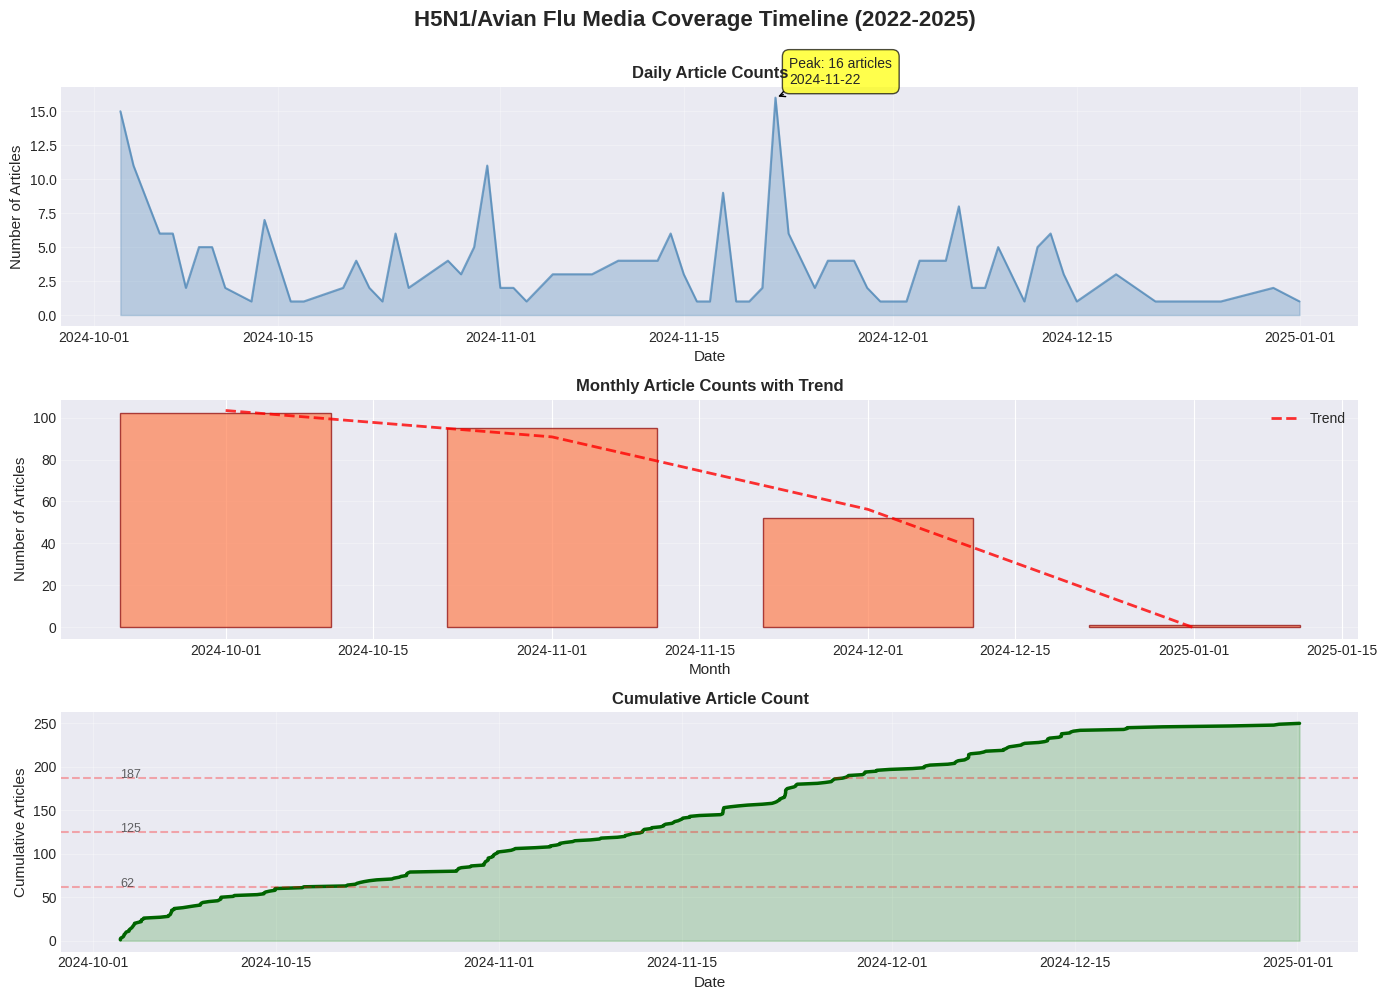

In [94]:
# GDELT H5N1/Avian Flu Query Tutorial - Part 3: Exploratory Data Analysis
# ==========================================================================

"""
In this final part, we'll perform exploratory data analysis including:
1. Timeline of article mentions
2. Coverage intensity over time
3. Analysis by source and domain
4. Keyword and thematic patterns
5. Geographic and temporal patterns
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from collections import Counter

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load cleaned data from Part 2
print("Loading cleaned data from Part 2...")
df = pd.read_csv('gdelt_h5n1_cleaned.csv')
df['date'] = pd.to_datetime(df['date'])
df['year_month'] = pd.to_datetime(df['year_month'])
print(f"Loaded {len(df)} articles\n")

# ============================================================================
# SECTION 1: Timeline Analysis
# ============================================================================
print("="*70)
print("SECTION 1: Timeline Analysis - Media Coverage Over Time")
print("="*70)

# Create figure with multiple subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('H5N1/Avian Flu Media Coverage Timeline (2022-2025)',
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Daily article counts
# -----------------------------
print("\n1.1 Creating daily article count timeline...")

daily_counts = df.groupby(df['date'].dt.date).size()

axes[0].plot(daily_counts.index, daily_counts.values,
             linewidth=1.5, alpha=0.7, color='steelblue')
axes[0].fill_between(daily_counts.index, daily_counts.values,
                      alpha=0.3, color='steelblue')
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Number of Articles', fontsize=11)
axes[0].set_title('Daily Article Counts', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Add annotation for peaks
peak_date = daily_counts.idxmax()
peak_value = daily_counts.max()
axes[0].annotate(f'Peak: {peak_value} articles\n{peak_date}',
                xy=(peak_date, peak_value),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

print(f"  Peak coverage: {peak_value} articles on {peak_date}")
print(f"  Average daily: {daily_counts.mean():.1f} articles")
print(f"  Median daily: {daily_counts.median():.1f} articles")

# Plot 2: Monthly article counts with trend
# ------------------------------------------
print("\n1.2 Creating monthly article count timeline...")

monthly_counts = df.groupby('year_month').size()
# Convert PeriodIndex to DatetimeIndex using to_timestamp()
monthly_dates = monthly_counts.index # Removed .to_timestamp()

axes[1].bar(monthly_dates, monthly_counts.values,
            width=20, alpha=0.7, color='coral', edgecolor='darkred')

# Add trend line (polynomial fit)
if len(monthly_counts) > 2:
    z = np.polyfit(range(len(monthly_counts)), monthly_counts.values, 2)
    p = np.poly1d(z)
    # Need to ensure the x-axis for the trend line is also datetime
    trend_dates = monthly_dates
    axes[1].plot(trend_dates, p(range(len(monthly_counts))),
                "r--", linewidth=2, label='Trend', alpha=0.8)
    axes[1].legend()

axes[1].set_xlabel('Month', fontsize=11)
axes[1].set_ylabel('Number of Articles', fontsize=11)
axes[1].set_title('Monthly Article Counts with Trend', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

print(f"  Busiest month: {monthly_counts.idxmax()} ({monthly_counts.max()} articles)")
print(f"  Quietest month: {monthly_counts.idxmin()} ({monthly_counts.min()} articles)")

# Plot 3: Cumulative articles over time
# --------------------------------------
print("\n1.3 Creating cumulative article timeline...")

df_sorted = df.sort_values('date').reset_index(drop=True)
cumulative = range(1, len(df_sorted) + 1)

axes[2].plot(df_sorted['date'], cumulative, linewidth=2.5, color='darkgreen')
axes[2].fill_between(df_sorted['date'], cumulative, alpha=0.2, color='green')
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_ylabel('Cumulative Articles', fontsize=11)
axes[2].set_title('Cumulative Article Count', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Add milestone markers
milestones = [len(df) // 4, len(df) // 2, 3 * len(df) // 4]
for milestone in milestones:
    if milestone < len(df_sorted):
        milestone_date = df_sorted.iloc[milestone]['date']
        axes[2].axhline(y=milestone, color='red', linestyle='--', alpha=0.3)
        axes[2].text(df_sorted['date'].min(), milestone,
                    f'{milestone}', fontsize=9, alpha=0.7)

print(f"  Total articles over period: {len(df)}")

plt.tight_layout()
plt.savefig('timeline_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Timeline saved as 'timeline_analysis.png'")
plt.show()


SECTION 2: Temporal Patterns - When Coverage Occurs

2.1 Analyzing day of week patterns...
  Most active day: Thursday (60 articles)
  Least active day: Saturday (16 articles)

2.2 Analyzing seasonal patterns...
  Busiest month: Oct (102 articles)

2.3 Creating year-month heatmap...

2.4 Calculating rolling average...

✓ Temporal patterns saved as 'temporal_patterns.png'


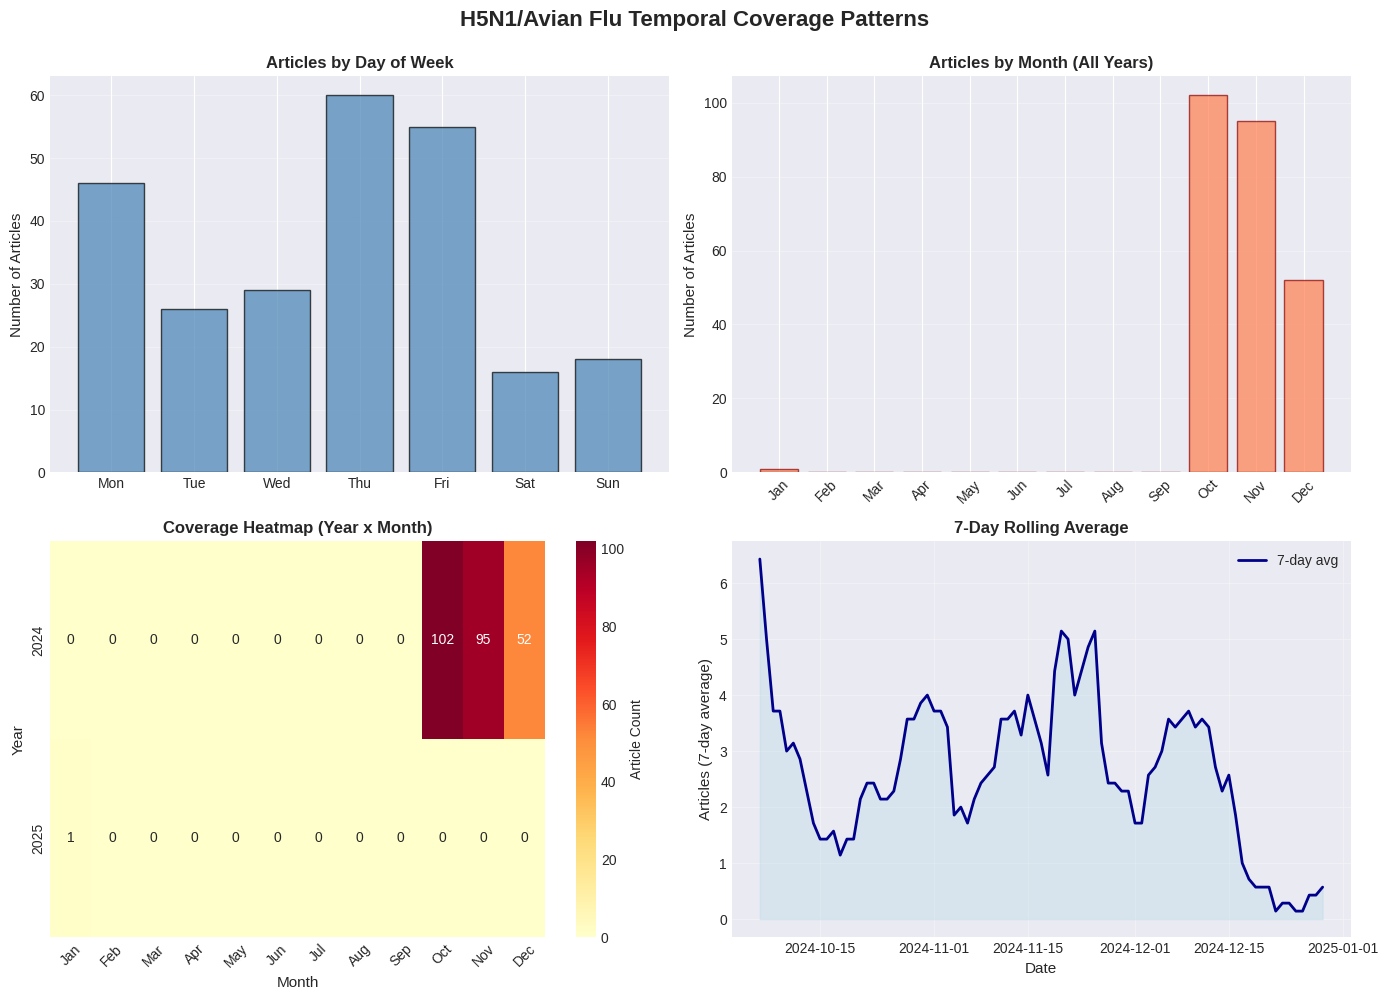

In [95]:
# ============================================================================
# SECTION 2: Temporal Patterns Analysis
# ============================================================================
print("\n" + "="*70)
print("SECTION 2: Temporal Patterns - When Coverage Occurs")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('H5N1/Avian Flu Temporal Coverage Patterns',
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Coverage by day of week
# --------------------------------
print("\n2.1 Analyzing day of week patterns...")

# Ensure 'day_of_week' column exists
if 'day_of_week' in df.columns:
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_counts = df['day_of_week'].value_counts().reindex(day_order, fill_value=0)

    axes[0, 0].bar(range(len(day_counts)), day_counts.values,
                   color='steelblue', alpha=0.7, edgecolor='black')
    axes[0, 0].set_xticks(range(len(day_counts)))
    axes[0, 0].set_xticklabels([d[:3] for d in day_order], rotation=0)
    axes[0, 0].set_ylabel('Number of Articles', fontsize=11)
    axes[0, 0].set_title('Articles by Day of Week', fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    print(f"  Most active day: {day_counts.idxmax()} ({day_counts.max()} articles)")
    print(f"  Least active day: {day_counts.idxmin()} ({day_counts.min()} articles)")
else:
    print("  'day_of_week' column not found. Skipping day of week analysis.")


# Plot 2: Coverage by month (aggregated across years)
# ----------------------------------------------------
print("\n2.2 Analyzing seasonal patterns...")

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_counts = df['month'].value_counts().sort_index()

axes[0, 1].bar(range(1, 13), [month_counts.get(i, 0) for i in range(1, 13)],
              color='coral', alpha=0.7, edgecolor='darkred')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(month_names, rotation=45)
axes[0, 1].set_ylabel('Number of Articles', fontsize=11)
axes[0, 1].set_title('Articles by Month (All Years)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

busiest_month_num = month_counts.idxmax()
print(f"  Busiest month: {month_names[int(busiest_month_num)-1]} ({month_counts.max()} articles)")

# Plot 3: Heatmap of coverage by year and month
# ----------------------------------------------
print("\n2.3 Creating year-month heatmap...")

# Create pivot table
heatmap_data = df.groupby(['year', 'month']).size().unstack(fill_value=0)

# Ensure we have all months
for month in range(1, 13):
    if month not in heatmap_data.columns:
        heatmap_data[month] = 0
heatmap_data = heatmap_data.sort_index(axis=1)

sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd',
            ax=axes[1, 0], cbar_kws={'label': 'Article Count'})
axes[1, 0].set_xlabel('Month', fontsize=11)
axes[1, 0].set_ylabel('Year', fontsize=11)
axes[1, 0].set_title('Coverage Heatmap (Year x Month)', fontsize=12, fontweight='bold')
axes[1, 0].set_xticklabels(month_names, rotation=45)

# Plot 4: Rolling average (7-day)
# --------------------------------
print("\n2.4 Calculating rolling average...")

# Ensure 'date' column is datetime
if 'date' in df.columns and pd.api.types.is_datetime64_any_dtype(df['date']):
    daily_counts_series = df.groupby(df['date'].dt.date).size().reindex(
        pd.date_range(df['date'].min().date(), df['date'].max().date()),
        fill_value=0
    )
    rolling_avg = daily_counts_series.rolling(window=7, center=True).mean()

    axes[1, 1].plot(rolling_avg.index, rolling_avg.values,
                   linewidth=2, color='darkblue', label='7-day avg')
    axes[1, 1].fill_between(rolling_avg.index, rolling_avg.values,
                            alpha=0.3, color='lightblue')
    axes[1, 1].set_xlabel('Date', fontsize=11)
    axes[1, 1].set_ylabel('Articles (7-day average)', fontsize=11)
    axes[1, 1].set_title('7-Day Rolling Average', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
else:
    print("  'date' column is not in datetime format. Skipping rolling average calculation.")


plt.tight_layout()
plt.savefig('temporal_patterns.png', dpi=300, bbox_inches='tight')
print("\n✓ Temporal patterns saved as 'temporal_patterns.png'")
plt.show()


SECTION 3: Source Analysis - Who's Covering the Story

3.1 Analyzing top news sources...
  Top 5 sources:
    1. yahoo.com: 23 articles
    2. cidrap.umn.edu: 9 articles
    3. news-medical.net: 6 articles
    4. medicalxpress.com: 6 articles
    5. thehindu.com: 5 articles

3.2 Analyzing domain categories...
  Domain category distribution:
    Other: 173 (69.2%)
    Local/Regional News: 40 (16.0%)
    Health/Medical: 15 (6.0%)
    Academic/Research: 10 (4.0%)
    Major News: 7 (2.8%)
    Government/Health Authority: 3 (1.2%)
    Agriculture: 2 (0.8%)

3.3 Analyzing domain coverage trends...

3.4 Analyzing language distribution...
  Top 3 languages:
    1. English: 250 (100.0%)

✓ Source analysis saved as 'source_analysis.png'


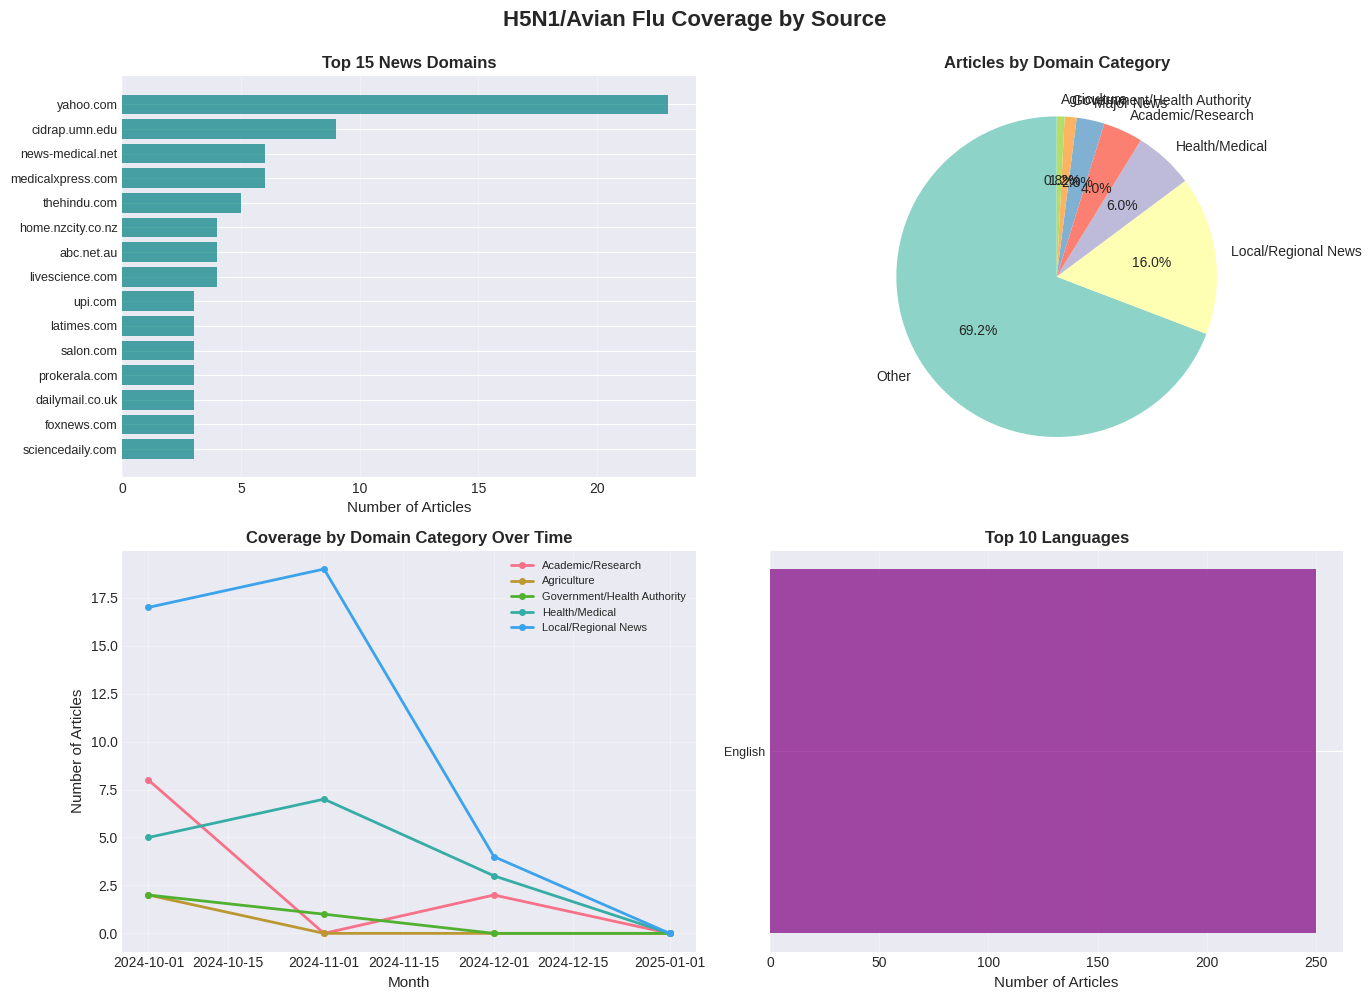

In [97]:
# ============================================================================
# SECTION 3: Source and Domain Analysis
# ============================================================================
print("\n" + "="*70)
print("SECTION 3: Source Analysis - Who's Covering the Story")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('H5N1/Avian Flu Coverage by Source',
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Top domains
# -------------------
print("\n3.1 Analyzing top news sources...")

top_domains = df['domain'].value_counts().head(15)

axes[0, 0].barh(range(len(top_domains)), top_domains.values, color='teal', alpha=0.7)
axes[0, 0].set_yticks(range(len(top_domains)))
axes[0, 0].set_yticklabels(top_domains.index, fontsize=9)
axes[0, 0].set_xlabel('Number of Articles', fontsize=11)
axes[0, 0].set_title('Top 15 News Domains', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')
axes[0, 0].invert_yaxis()

print(f"  Top 5 sources:")
for i, (domain, count) in enumerate(top_domains.head(5).items(), 1):
    print(f"    {i}. {domain}: {count} articles")

# Plot 2: Domain category distribution
# -------------------------------------
print("\n3.2 Analyzing domain categories...")

domain_cat_counts = df['domain_category'].value_counts()

colors_cat = sns.color_palette("Set3", len(domain_cat_counts))
axes[0, 1].pie(domain_cat_counts.values, labels=domain_cat_counts.index,
              autopct='%1.1f%%', startangle=90, colors=colors_cat)
axes[0, 1].set_title('Articles by Domain Category', fontsize=12, fontweight='bold')

print(f"  Domain category distribution:")
for dtype, count in domain_cat_counts.items():
    print(f"    {dtype}: {count} ({100*count/len(df):.1f}%)")

# Plot 3: Domain category over time
# ----------------------------------
print("\n3.3 Analyzing domain coverage trends...")

domain_time = df.groupby(['year_month', 'domain_category']).size().unstack(fill_value=0)
domain_time_dates = domain_time.index # Removed .to_timestamp()

for category in domain_time.columns[:5]:  # Top 5 categories
    axes[1, 0].plot(domain_time_dates, domain_time[category],
                   marker='o', label=category, linewidth=2, markersize=4)

axes[1, 0].set_xlabel('Month', fontsize=11)
axes[1, 0].set_ylabel('Number of Articles', fontsize=11)
axes[1, 0].set_title('Coverage by Domain Category Over Time', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=8)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Language distribution
# ------------------------------
print("\n3.4 Analyzing language distribution...")

if 'language' in df.columns:
    lang_counts = df['language'].value_counts().head(10)

    axes[1, 1].barh(range(len(lang_counts)), lang_counts.values,
                   color='purple', alpha=0.7)
    axes[1, 1].set_yticks(range(len(lang_counts)))
    axes[1, 1].set_yticklabels(lang_counts.index, fontsize=9)
    axes[1, 1].set_xlabel('Number of Articles', fontsize=11)
    axes[1, 1].set_title('Top 10 Languages', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    axes[1, 1].invert_yaxis()

    print(f"  Top 3 languages:")
    for i, (lang, count) in enumerate(lang_counts.head(3).items(), 1):
        print(f"    {i}. {lang}: {count} ({100*count/len(df):.1f}%)")
else:
    axes[1, 1].text(0.5, 0.5, 'Language data not available',
                   ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Language Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('source_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Source analysis saved as 'source_analysis.png'")
plt.show()


SECTION 4: Keyword Analysis - What's Being Discussed

4.1 Analyzing keyword mentions...
  Top keywords:
    1. Bird Flu: 199 articles (79.6%)
    2. Poultry: 171 articles (68.4%)
    3. H5N1: 91 articles (36.4%)
    4. Human: 46 articles (18.4%)
    5. Case: 41 articles (16.4%)

4.2 Analyzing keyword trends over time...

4.3 Analyzing title characteristics...
  Mean title length: 71 characters
  Median title length: 68 characters

4.4 Analyzing keyword co-occurrence...

✓ Keyword analysis saved as 'keyword_analysis.png'


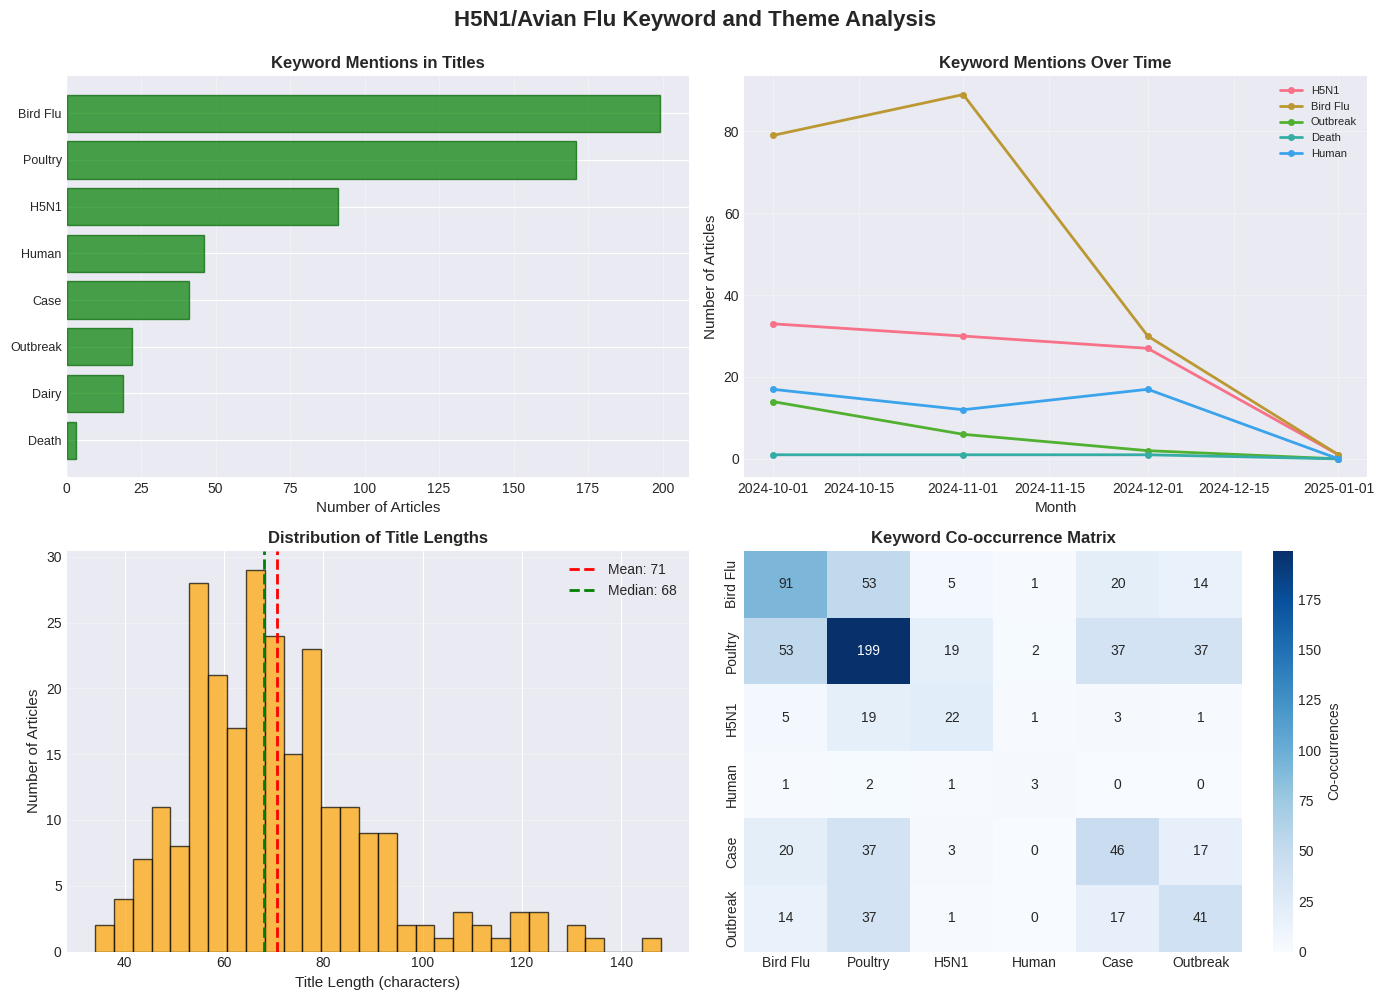

In [101]:
# ============================================================================
# SECTION 4: Keyword and Theme Analysis
# ============================================================================
print("\n" + "="*70)
print("SECTION 4: Keyword Analysis - What's Being Discussed")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('H5N1/Avian Flu Keyword and Theme Analysis',
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Keyword mentions in titles
# -----------------------------------
print("\n4.1 Analyzing keyword mentions...")

keyword_cols = [col for col in df.columns if col.startswith('mentions_')]
keyword_names = [col.replace('mentions_', '').replace('_', ' ').title()
                for col in keyword_cols]
keyword_counts = [df[col].sum() for col in keyword_cols]

# Sort by count
sorted_indices = np.argsort(keyword_counts)[::-1]
keyword_names = [keyword_names[i] for i in sorted_indices]
keyword_counts = [keyword_counts[i] for i in sorted_indices]

axes[0, 0].barh(range(len(keyword_names)), keyword_counts,
               color='green', alpha=0.7, edgecolor='darkgreen')
axes[0, 0].set_yticks(range(len(keyword_names)))
axes[0, 0].set_yticklabels(keyword_names, fontsize=9)
axes[0, 0].set_xlabel('Number of Articles', fontsize=11)
axes[0, 0].set_title('Keyword Mentions in Titles', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')
axes[0, 0].invert_yaxis()

print(f"  Top keywords:")
for i, (name, count) in enumerate(zip(keyword_names[:5], keyword_counts[:5]), 1):
    print(f"    {i}. {name}: {count} articles ({100*count/len(df):.1f}%)")

# Plot 2: Keyword trends over time
# ---------------------------------
print("\n4.2 Analyzing keyword trends over time...")

# Select top keywords to plot
top_keywords = keyword_cols[:5] if len(keyword_cols) >= 5 else keyword_cols

for col in top_keywords:
    keyword_time = df.groupby('year_month')[col].sum()
    keyword_dates = keyword_time.index # Removed .to_timestamp()
    label = col.replace('mentions_', '').replace('_', ' ').title()
    axes[0, 1].plot(keyword_dates, keyword_time.values,
                   marker='o', label=label, linewidth=2, markersize=4)

axes[0, 1].set_xlabel('Month', fontsize=11)
axes[0, 1].set_ylabel('Number of Articles', fontsize=11)
axes[0, 1].set_title('Keyword Mentions Over Time', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Title length distribution
# ----------------------------------
print("\n4.3 Analyzing title characteristics...")

if 'title_length' in df.columns:
    axes[1, 0].hist(df['title_length'].dropna(), bins=30,
                   color='orange', edgecolor='black', alpha=0.7)
    axes[1, 0].axvline(x=df['title_length'].mean(), color='red',
                      linestyle='--', linewidth=2,
                      label=f'Mean: {df["title_length"].mean():.0f}')
    axes[1, 0].axvline(x=df['title_length'].median(), color='green',
                      linestyle='--', linewidth=2,
                      label=f'Median: {df["title_length"].median():.0f}')
    axes[1, 0].set_xlabel('Title Length (characters)', fontsize=11)
    axes[1, 0].set_ylabel('Number of Articles', fontsize=11)
    axes[1, 0].set_title('Distribution of Title Lengths', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    print(f"  Mean title length: {df['title_length'].mean():.0f} characters")
    print(f"  Median title length: {df['title_length'].median():.0f} characters")

# Plot 4: Co-occurrence of keywords
# ----------------------------------
print("\n4.4 Analyzing keyword co-occurrence...")

# Create co-occurrence matrix for top keywords
if len(keyword_cols) > 1:
    cooccur = pd.DataFrame(index=keyword_names[:6], columns=keyword_names[:6])

    for i, col1 in enumerate(keyword_cols[:6]):
        for j, col2 in enumerate(keyword_cols[:6]):
            count = (df[col1] & df[col2]).sum()
            cooccur.iloc[i, j] = count

    cooccur = cooccur.astype(float)

    sns.heatmap(cooccur, annot=True, fmt='.0f', cmap='Blues',
               ax=axes[1, 1], cbar_kws={'label': 'Co-occurrences'})
    axes[1, 1].set_title('Keyword Co-occurrence Matrix', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('')
    axes[1, 1].set_ylabel('')

plt.tight_layout()
plt.savefig('keyword_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Keyword analysis saved as 'keyword_analysis.png'")
plt.show()

In [109]:


# ============================================================================
# SECTION 5: Summary Statistics and Insights
# ============================================================================
print("\n" + "="*70)
print("SECTION 5: Summary Statistics and Key Insights")
print("="*70)

print("\n📊 DATASET OVERVIEW")
print("-" * 70)
print(f"  Total articles: {len(df):,}")
print(f"  Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"  Time span: {(df['date'].max() - df['date'].min()).days} days")
print(f"  Unique domains: {df['domain'].nunique():,}")

print("\n📈 COVERAGE PATTERNS")
print("-" * 70)
daily_avg = df.groupby(df['date'].dt.date).size().mean()
weekly_avg = df.groupby('week').size().mean()
monthly_avg = df.groupby('year_month').size().mean()
print(f"  Average articles per day: {daily_avg:.1f}")
print(f"  Average articles per week: {weekly_avg:.1f}")
print(f"  Average articles per month: {monthly_avg:.1f}")

print("\n📅 PEAK COVERAGE PERIODS")
print("-" * 70)
peak_date = daily_counts.idxmax()
peak_count = daily_counts.max()
print(f"  Peak day: {peak_date}")
print(f"  Articles on peak day: {peak_count}")

# Find top 5 days
top_days = daily_counts.nlargest(5)
print(f"\n  Top 5 busiest days:")
for i, (date, count) in enumerate(top_days.items(), 1):
    print(f"    {i}. {date}: {count} articles")

print("\n📰 TOP NEWS SOURCES")
print("-" * 70)
for i, (domain, count) in enumerate(df['domain'].value_counts().head(10).items(), 1):
    pct = 100 * count / len(df)
    print(f"  {i:2d}. {domain:40s} {count:4d} articles ({pct:5.1f}%)")

print("\n🏷️  DOMAIN CATEGORIES")
print("-" * 70)
for cat, count in df['domain_category'].value_counts().items():
    pct = 100 * count / len(df)
    print(f"  {cat:30s} {count:4d} articles ({pct:5.1f}%)")

if 'language' in df.columns:
    print("\n🌍 LANGUAGE DISTRIBUTION")
    print("-" * 70)
    for lang, count in df['language'].value_counts().head(5).items():
        pct = 100 * count / len(df)
        print(f"  {lang:20s} {count:4d} articles ({pct:5.1f}%)")

print("\n🔑 KEYWORD INSIGHTS")
print("-" * 70)
for col in keyword_cols:
    keyword_name = col.replace('mentions_', '').replace('_', ' ').title()
    count = df[col].sum()
    pct = 100 * count / len(df)
    print(f"  {keyword_name:20s} {count:4d} mentions ({pct:5.1f}%)")

print("\n📊 COVERAGE BY YEAR")
print("-" * 70)
yearly_counts = df.groupby('year').size().sort_index()
for year, count in yearly_counts.items():
    if not pd.isna(year):
        # Calculate days in that year within our date range
        year_start = max(df['date'].min(), pd.Timestamp(f'{int(year)}-01-01'))
        year_end = min(df['date'].max(), pd.Timestamp(f'{int(year)}-12-31'))
        days = (year_end - year_start).days + 1
        avg_per_day = count / days
        print(f"  {int(year)}: {count:4d} articles ({avg_per_day:.2f} per day)")

print("\n⏰ TEMPORAL PATTERNS")
print("-" * 70)
print("  Most active day of week:")
for day, count in df['day_of_week'].value_counts().head(3).items():
    pct = 100 * count / len(df)
    print(f"    {day:10s} {count:4d} articles ({pct:5.1f}%)")

print("\n  Most active months (all years combined):")
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month_num, count in df['month'].value_counts().head(3).items():
    pct = 100 * count / len(df)
    print(f"    {month_names[int(month_num)-1]:10s} {count:4d} articles ({pct:5.1f}%)")

# Calculate growth rate
if len(yearly_counts) > 1:
    years_list = sorted([int(y) for y in yearly_counts.index if not pd.isna(y)])
    if len(years_list) >= 2:
        first_year = years_list[0]
        last_year = years_list[-1]
        first_count = yearly_counts[first_year]
        last_count = yearly_counts[last_year]

        print("\n📈 COVERAGE TRENDS")
        print("-" * 70)
        print(f"  {first_year} coverage: {first_count} articles")
        print(f"  {last_year} coverage: {last_count} articles")

        if first_count > 0:
            change_pct = ((last_count - first_count) / first_count) * 100
            print(f"  Change: {change_pct:+.1f}%")

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print("\n📁 Generated files:")
print("  ✓ timeline_analysis.png")
print("  ✓ temporal_patterns.png")
print("  ✓ source_analysis.png")
print("  ✓ keyword_analysis.png")
print("  ✓ gdelt_h5n1_cleaned.csv")

print("\n💡 Key Insights Summary:")
print(f"  • Coverage peaked on {peak_date} with {peak_count} articles")
print(f"  • Average of {daily_avg:.1f} articles per day over the period")
print(f"  • Top source: {df['domain'].value_counts().index[0]} " +
      f"({df['domain'].value_counts().iloc[0]} articles)")
print(f"  • Most common domain type: {df['domain_category'].value_counts().index[0]} " +
      f"({100*df['domain_category'].value_counts().iloc[0]/len(df):.1f}%)")

if keyword_counts:
    top_keyword_idx = np.argmax(keyword_counts)
    print(f"  • Most mentioned keyword: {keyword_names[top_keyword_idx]} " +
          f"({keyword_counts[top_keyword_idx]} articles)")

print("\n" + "="*70)


SECTION 5: Summary Statistics and Key Insights

📊 DATASET OVERVIEW
----------------------------------------------------------------------
  Total articles: 250
  Date range: 2024-10-03 to 2025-01-01
  Time span: 90 days
  Unique domains: 143

📈 COVERAGE PATTERNS
----------------------------------------------------------------------
  Average articles per day: 3.7
  Average articles per week: 17.9
  Average articles per month: 62.5

📅 PEAK COVERAGE PERIODS
----------------------------------------------------------------------
  Peak day: 2024-11-22
  Articles on peak day: 16

  Top 5 busiest days:
    1. 2024-11-22: 16 articles
    2. 2024-10-03: 15 articles
    3. 2024-10-04: 11 articles
    4. 2024-10-31: 11 articles
    5. 2024-11-18: 9 articles

📰 TOP NEWS SOURCES
----------------------------------------------------------------------
   1. yahoo.com                                  23 articles (  9.2%)
   2. cidrap.umn.edu                              9 articles (  3.6%)
   3. news

In [162]:
# GDELT H5N1/Avian Flu Query Tutorial - Part 4: Tone Data Analysis
# ===================================================================

"""
In this part, we'll retrieve tone data from GDELT and perform EDA.
Note: The basic ArtList mode doesn't include tone, so we'll use the
TimelineTone mode to get aggregate tone trends over time.

IMPORTANT: The GDELT DOC API officially supports only the last 3 months
of data. For older date ranges, use the method in the Bonus tutorial to
download raw GKG files.
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
from datetime import datetime, timedelta

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# STEP 1: Query GDELT for Tone Data
# ============================================================================

print("="*70)
print("STEP 1: Querying GDELT for Tone Data")
print("="*70)

# OPTION A: Use recent date range (recommended - last 90 days)
# -------------------------------------------------------------
print("\n📌 Using recent date range (last 90 days) for reliable results...")
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=90)).strftime('%Y-%m-%d')

# OPTION B: Use custom date range (may not work for old dates)
# -------------------------------------------------------------
# Uncomment to use custom dates (but GDELT officially supports last 3 months only)
start_date = "2022-01-01"
end_date = "2025-01-01"

search_terms = ["H5N1", "avian flu", "bird flu", "avian influenza"]
search_query = "H5N1"

print(f"\nSearch query: {search_query}")
print(f"Date range: {start_date} to {end_date}")

# Convert dates to GDELT format
start_dt = start_date.replace("-", "") + "000000"
end_dt = end_date.replace("-", "") + "000000"

# Build URL for TimelineTone mode
base_url = "https://api.gdeltproject.org/api/v2/doc/doc"
params = {
    "query": search_query,
    "mode": "TimelineTone",  # This returns tone data over time
    "format": "json",
    "startdatetime": start_dt,
    "enddatetime": end_dt
}

print("\nQuerying GDELT TimelineTone API...")

try:
    response = requests.get(base_url, params=params, timeout=30)

    if response.status_code == 200:
        print("✓ Successfully retrieved response from GDELT")
        data = response.json()

        # Debug: Print the structure of the response
        print(f"\nDEBUG - Response keys: {list(data.keys())}")

        if 'timeline' in data:
            print(f"DEBUG - Timeline found with {len(data['timeline'])} entries")
            if len(data['timeline']) > 0:
                print(f"DEBUG - First timeline entry: {data['timeline'][0]}")

                # Check if it's in the format we expect
                first_entry = data['timeline'][0]

                # Handle different response formats
                if isinstance(first_entry, dict) and 'series' in first_entry:
                    # Format: [{'series': 'Average Tone', 'data': [{'date': '...', 'value': ...}, ...]}]
                    print("DEBUG - Detected 'series' format")
                    if 'data' in first_entry:
                        tone_df = pd.DataFrame(first_entry['data'])
                        print(f"✓ Retrieved tone data for {len(tone_df)} time points")
                        print(f"DEBUG - DataFrame columns: {list(tone_df.columns)}")
                    else:
                        print("⚠ No 'data' key in series")
                        tone_df = pd.DataFrame()
                elif isinstance(first_entry, dict) and 'date' in first_entry:
                    # Format: [{'date': '...', 'value': ...}, ...]
                    print("DEBUG - Detected direct date/value format")
                    tone_df = pd.DataFrame(data['timeline'])
                    print(f"✓ Retrieved tone data for {len(tone_df)} time points")
                    print(f"DEBUG - DataFrame columns: {list(tone_df.columns)}")
                else:
                    print(f"⚠ Unexpected timeline format: {type(first_entry)}")
                    print(f"  First entry: {first_entry}")
                    tone_df = pd.DataFrame()
            else:
                print("⚠ Timeline is empty - no articles match in this date range")
                print("  Try a shorter, more recent date range (last 3 months)")
                tone_df = pd.DataFrame()
        else:
            print("⚠ No 'timeline' key in response")
            print(f"  Available keys: {list(data.keys())}")
            tone_df = pd.DataFrame()
    else:
        print(f"✗ Error: Status code {response.status_code}")
        if response.text:
            print(f"  Response: {response.text[:200]}")
        tone_df = pd.DataFrame()

except Exception as e:
    print(f"✗ Error: {str(e)}")
    import traceback
    traceback.print_exc()
    tone_df = pd.DataFrame()

STEP 1: Querying GDELT for Tone Data

📌 Using recent date range (last 90 days) for reliable results...

Search query: H5N1
Date range: 2022-01-01 to 2025-01-01

Querying GDELT TimelineTone API...
✓ Successfully retrieved response from GDELT

DEBUG - Response keys: ['query_details', 'timeline']
DEBUG - Timeline found with 1 entries
DEBUG - First timeline entry: {'series': 'Average Tone', 'data': [{'date': '20220101T000000Z', 'value': -3.6394}, {'date': '20220102T000000Z', 'value': -3.8722}, {'date': '20220103T000000Z', 'value': -4.1834}, {'date': '20220104T000000Z', 'value': -4.9284}, {'date': '20220105T000000Z', 'value': -4.7096}, {'date': '20220106T000000Z', 'value': -4.3775}, {'date': '20220107T000000Z', 'value': -4.3194}, {'date': '20220108T000000Z', 'value': -4.5838}, {'date': '20220109T000000Z', 'value': -4.0407}, {'date': '20220110T000000Z', 'value': -4.2447}, {'date': '20220111T000000Z', 'value': -4.7744}, {'date': '20220112T000000Z', 'value': -3.573}, {'date': '20220113T000000Z

In [163]:
# ============================================================================
# STEP 2: Parse and Clean Tone Data
# ============================================================================

print("\n" + "="*70)
print("STEP 2: Parsing and Cleaning Tone Data")
print("="*70)

if tone_df.empty:
    print("✗ Tone data is empty. This could mean:")
    print("  1. The API doesn't support tone data for date ranges this old")
    print("  2. The search returned no results")
    print("  3. The date range is too long")
    print("\n💡 GDELT DOC API officially supports only the last 3 months.")
    print("   Try using a more recent date range like the last 90 days.")
    print("\nExample for recent data:")
    print("  from datetime import datetime, timedelta")
    print("  end_date = datetime.now().strftime('%Y-%m-%d')")
    print("  start_date = (datetime.now() - timedelta(days=90)).strftime('%Y-%m-%d')")

elif not isinstance(tone_df, pd.DataFrame):
    print("✗ Tone data is in unexpected format")
    print(f"  Type: {type(tone_df)}")
    print(f"  Value: {tone_df}")

else:
    # Parse date field
    tone_df['date'] = pd.to_datetime(tone_df['date'], format='%Y%m%dT%H%M%SZ', errors='coerce')

    # Rename 'value' column to 'avg_tone'
    tone_df = tone_df.rename(columns={'value': 'avg_tone'})

    # Create additional date features
    tone_df['year'] = tone_df['date'].dt.year
    tone_df['month'] = tone_df['date'].dt.month
    tone_df['year_month'] = tone_df['date'].dt.to_period('M')

    # Sort by date
    tone_df = tone_df.sort_values('date').reset_index(drop=True)

    print(f"✓ Parsed dates successfully")
    print(f"  Date range: {tone_df['date'].min()} to {tone_df['date'].max()}")
    print(f"  Total time points: {len(tone_df)}")

    # Basic statistics
    print(f"\nTone statistics:")
    print(f"  Mean: {tone_df['avg_tone'].mean():.2f}")
    print(f"  Median: {tone_df['avg_tone'].median():.2f}")
    print(f"  Std Dev: {tone_df['avg_tone'].std():.2f}")
    print(f"  Min: {tone_df['avg_tone'].min():.2f}")
    print(f"  Max: {tone_df['avg_tone'].max():.2f}")

    # Save cleaned tone data
    tone_df.to_csv('gdelt_h5n1_tone.csv', index=False)
    print("\n✓ Saved tone data to 'gdelt_h5n1_tone.csv'")

    # Show first few rows
    print("\nFirst few rows:")
    print(tone_df[['date', 'avg_tone']].head())


STEP 2: Parsing and Cleaning Tone Data
✓ Parsed dates successfully
  Date range: 2022-01-01 00:00:00 to 2025-01-01 00:00:00
  Total time points: 1096

Tone statistics:
  Mean: -3.78
  Median: -3.85
  Std Dev: 1.42
  Min: -9.96
  Max: 1.31

✓ Saved tone data to 'gdelt_h5n1_tone.csv'

First few rows:
        date  avg_tone
0 2022-01-01   -3.6394
1 2022-01-02   -3.8722
2 2022-01-03   -4.1834
3 2022-01-04   -4.9284
4 2022-01-05   -4.7096



STEP 3: Tone Data Exploratory Analysis

3.1 Creating tone timeline...
  Most positive: 1.31 on 2023-05-30
  Most negative: -9.96 on 2023-07-22

3.2 Analyzing tone distribution...
  Positive periods: 0.3%
  Negative periods: 96.0%
  Neutral periods: 3.7%

3.3 Calculating monthly tone averages...
  Most positive month: 2023-12 (tone: -2.91)
  Most negative month: 2023-07 (tone: -4.91)

3.4 Analyzing tone volatility...
  Average volatility: 1.30

✓ Saved tone analysis to 'tone_eda.png'


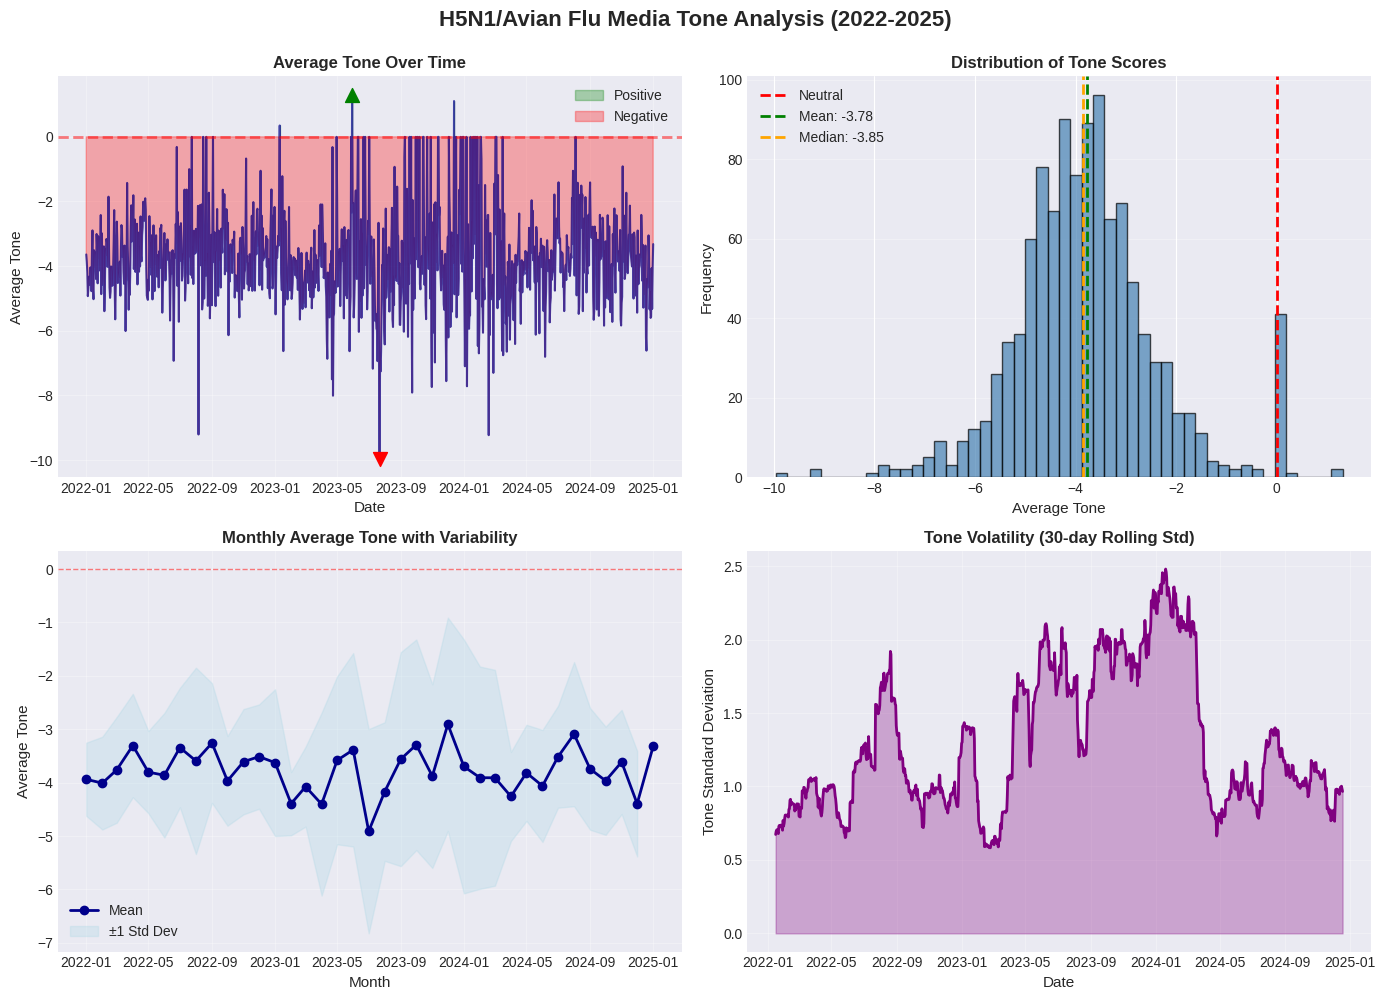


STEP 4: Advanced Tone Analysis

4.1 Comparing tone by year...
  Yearly averages:
    2022: -3.66 (±1.07)
    2023: -3.84 (±1.69)
    2024: -3.83 (±1.42)
    2025: -3.32 (±nan)

4.2 Categorizing tone periods...
  Tone categories:
    Negative: 1003 periods (91.5%)
    Neutral: 93 periods (8.5%)

4.3 Calculating cumulative tone...
  Final cumulative tone: -4140.40

4.4 Analyzing tone change rate...
  Average absolute change: 1.30

✓ Saved advanced tone analysis to 'tone_advanced.png'


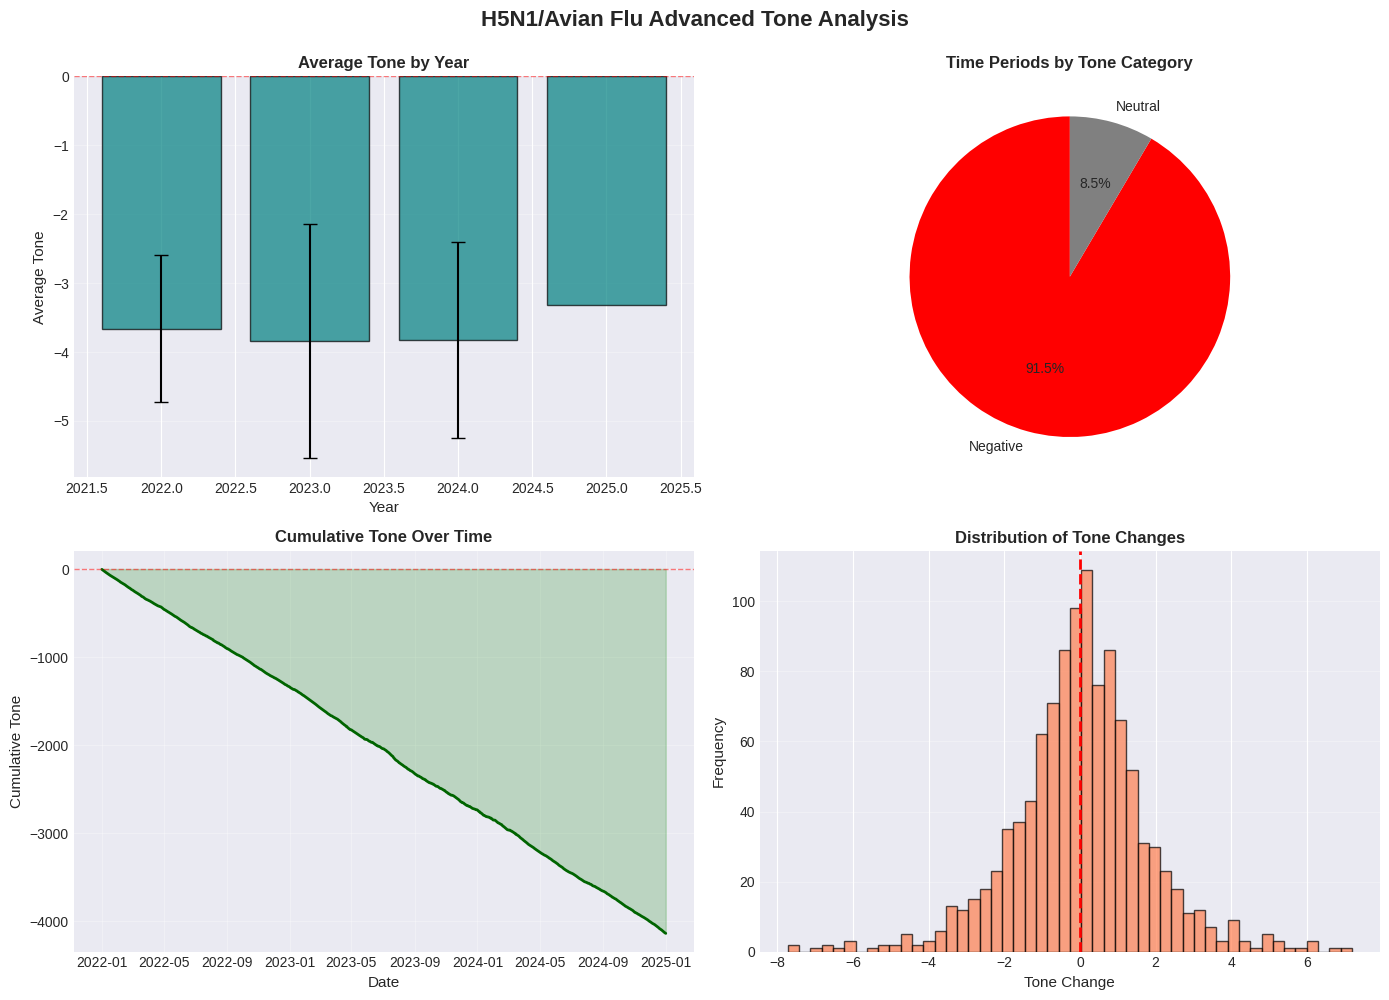


STEP 5: Tone Data Summary

📊 OVERALL TONE STATISTICS
----------------------------------------------------------------------
  Number of time points: 1096
  Date range: 2022-01-01 to 2025-01-01
  Mean tone: -3.78
  Median tone: -3.85
  Standard deviation: 1.42
  Range: -9.96 to 1.31

📈 TONE TRENDS
----------------------------------------------------------------------
  Positive periods: 3 (0.3%)
  Negative periods: 1052 (96.0%)
  Neutral periods: 41 (3.7%)
  Average volatility: 1.30
  Final cumulative tone: -4140.40

🎯 KEY MOMENTS
----------------------------------------------------------------------
  Most positive: 1.31 on 2023-05-30
  Most negative: -9.96 on 2023-07-22
  Most positive month: 2023-12
  Most negative month: 2023-07

TONE ANALYSIS COMPLETE!

📁 Generated files:
  ✓ tone_eda.png
  ✓ tone_advanced.png
  ✓ gdelt_h5n1_tone.csv



In [164]:
# ============================================================================
# STEP 3: Exploratory Data Analysis - Tone Visualizations
# ============================================================================

print("\n" + "="*70)
print("STEP 3: Tone Data Exploratory Analysis")
print("="*70)

if not tone_df.empty:
    # Create comprehensive tone analysis figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('H5N1/Avian Flu Media Tone Analysis (2022-2025)',
                 fontsize=16, fontweight='bold', y=0.995)

    # Plot 1: Tone over time
    # ----------------------
    print("\n3.1 Creating tone timeline...")

    axes[0, 0].plot(tone_df['date'], tone_df['avg_tone'],
                   linewidth=1.5, color='darkblue', alpha=0.7)
    axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5)
    axes[0, 0].fill_between(tone_df['date'], tone_df['avg_tone'], 0,
                           where=(tone_df['avg_tone'] > 0),
                           alpha=0.3, color='green', label='Positive')
    axes[0, 0].fill_between(tone_df['date'], tone_df['avg_tone'], 0,
                           where=(tone_df['avg_tone'] <= 0),
                           alpha=0.3, color='red', label='Negative')
    axes[0, 0].set_xlabel('Date', fontsize=11)
    axes[0, 0].set_ylabel('Average Tone', fontsize=11)
    axes[0, 0].set_title('Average Tone Over Time', fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Find most positive and negative points
    most_positive = tone_df.loc[tone_df['avg_tone'].idxmax()]
    most_negative = tone_df.loc[tone_df['avg_tone'].idxmin()]

    axes[0, 0].scatter(most_positive['date'], most_positive['avg_tone'],
                      color='green', s=100, zorder=5, marker='^')
    axes[0, 0].scatter(most_negative['date'], most_negative['avg_tone'],
                      color='red', s=100, zorder=5, marker='v')

    print(f"  Most positive: {most_positive['avg_tone']:.2f} on {most_positive['date'].date()}")
    print(f"  Most negative: {most_negative['avg_tone']:.2f} on {most_negative['date'].date()}")

    # Plot 2: Tone distribution
    # -------------------------
    print("\n3.2 Analyzing tone distribution...")

    axes[0, 1].hist(tone_df['avg_tone'], bins=50, color='steelblue',
                   edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutral')
    axes[0, 1].axvline(x=tone_df['avg_tone'].mean(), color='green',
                      linestyle='--', linewidth=2,
                      label=f'Mean: {tone_df["avg_tone"].mean():.2f}')
    axes[0, 1].axvline(x=tone_df['avg_tone'].median(), color='orange',
                      linestyle='--', linewidth=2,
                      label=f'Median: {tone_df["avg_tone"].median():.2f}')
    axes[0, 1].set_xlabel('Average Tone', fontsize=11)
    axes[0, 1].set_ylabel('Frequency', fontsize=11)
    axes[0, 1].set_title('Distribution of Tone Scores', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # Calculate percentages
    positive_pct = 100 * (tone_df['avg_tone'] > 0).sum() / len(tone_df)
    negative_pct = 100 * (tone_df['avg_tone'] < 0).sum() / len(tone_df)
    neutral_pct = 100 * (tone_df['avg_tone'] == 0).sum() / len(tone_df)

    print(f"  Positive periods: {positive_pct:.1f}%")
    print(f"  Negative periods: {negative_pct:.1f}%")
    print(f"  Neutral periods: {neutral_pct:.1f}%")

    # Plot 3: Monthly average tone
    # ----------------------------
    print("\n3.3 Calculating monthly tone averages...")

    monthly_tone = tone_df.groupby('year_month')['avg_tone'].agg(['mean', 'std', 'min', 'max'])
    monthly_dates = [period.to_timestamp() for period in monthly_tone.index]

    axes[1, 0].plot(monthly_dates, monthly_tone['mean'],
                   marker='o', linewidth=2, markersize=6, color='darkblue', label='Mean')
    axes[1, 0].fill_between(monthly_dates,
                           monthly_tone['mean'] - monthly_tone['std'],
                           monthly_tone['mean'] + monthly_tone['std'],
                           alpha=0.3, color='lightblue', label='±1 Std Dev')
    axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[1, 0].set_xlabel('Month', fontsize=11)
    axes[1, 0].set_ylabel('Average Tone', fontsize=11)
    axes[1, 0].set_title('Monthly Average Tone with Variability', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Find most positive and negative months
    most_pos_month = monthly_tone['mean'].idxmax()
    most_neg_month = monthly_tone['mean'].idxmin()

    print(f"  Most positive month: {most_pos_month} (tone: {monthly_tone.loc[most_pos_month, 'mean']:.2f})")
    print(f"  Most negative month: {most_neg_month} (tone: {monthly_tone.loc[most_neg_month, 'mean']:.2f})")

    # Plot 4: Tone volatility over time
    # ---------------------------------
    print("\n3.4 Analyzing tone volatility...")

    # Calculate rolling standard deviation (30-day window)
    tone_df['rolling_std'] = tone_df['avg_tone'].rolling(window=30, center=True).std()

    axes[1, 1].plot(tone_df['date'], tone_df['rolling_std'],
                   linewidth=2, color='purple')
    axes[1, 1].fill_between(tone_df['date'], tone_df['rolling_std'],
                           alpha=0.3, color='purple')
    axes[1, 1].set_xlabel('Date', fontsize=11)
    axes[1, 1].set_ylabel('Tone Standard Deviation', fontsize=11)
    axes[1, 1].set_title('Tone Volatility (30-day Rolling Std)', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    avg_volatility = tone_df['rolling_std'].mean()
    print(f"  Average volatility: {avg_volatility:.2f}")

    plt.tight_layout()
    plt.savefig('tone_eda.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved tone analysis to 'tone_eda.png'")
    plt.show()

    # ========================================================================
    # STEP 4: Advanced Tone Analysis
    # ========================================================================

    print("\n" + "="*70)
    print("STEP 4: Advanced Tone Analysis")
    print("="*70)

    # Create additional analysis figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('H5N1/Avian Flu Advanced Tone Analysis',
                 fontsize=16, fontweight='bold', y=0.995)

    # Plot 1: Yearly tone comparison
    # ------------------------------
    print("\n4.1 Comparing tone by year...")

    yearly_tone = tone_df.groupby('year')['avg_tone'].agg(['mean', 'std'])

    axes[0, 0].bar(yearly_tone.index, yearly_tone['mean'],
                  yerr=yearly_tone['std'], capsize=5,
                  color='teal', alpha=0.7, edgecolor='black')
    axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[0, 0].set_xlabel('Year', fontsize=11)
    axes[0, 0].set_ylabel('Average Tone', fontsize=11)
    axes[0, 0].set_title('Average Tone by Year', fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    print(f"  Yearly averages:")
    for year, row in yearly_tone.iterrows():
        if not pd.isna(year):
            print(f"    {int(year)}: {row['mean']:.2f} (±{row['std']:.2f})")

    # Plot 2: Tone categories pie chart
    # ---------------------------------
    print("\n4.2 Categorizing tone periods...")

    def categorize_tone(score):
        if score > 2:
            return 'Positive'
        elif score < -2:
            return 'Negative'
        else:
            return 'Neutral'

    tone_df['tone_category'] = tone_df['avg_tone'].apply(categorize_tone)
    tone_cats = tone_df['tone_category'].value_counts()

    colors = {'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}
    pie_colors = [colors[cat] for cat in tone_cats.index]

    axes[0, 1].pie(tone_cats.values, labels=tone_cats.index, autopct='%1.1f%%',
                  colors=pie_colors, startangle=90)
    axes[0, 1].set_title('Time Periods by Tone Category', fontsize=12, fontweight='bold')

    print(f"  Tone categories:")
    for cat, count in tone_cats.items():
        print(f"    {cat}: {count} periods ({100*count/len(tone_df):.1f}%)")

    # Plot 3: Cumulative tone
    # -----------------------
    print("\n4.3 Calculating cumulative tone...")

    tone_df['cumulative_tone'] = tone_df['avg_tone'].cumsum()

    axes[1, 0].plot(tone_df['date'], tone_df['cumulative_tone'],
                   linewidth=2, color='darkgreen')
    axes[1, 0].fill_between(tone_df['date'], tone_df['cumulative_tone'],
                           alpha=0.2, color='green')
    axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[1, 0].set_xlabel('Date', fontsize=11)
    axes[1, 0].set_ylabel('Cumulative Tone', fontsize=11)
    axes[1, 0].set_title('Cumulative Tone Over Time', fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    final_cumulative = tone_df['cumulative_tone'].iloc[-1]
    print(f"  Final cumulative tone: {final_cumulative:.2f}")

    # Plot 4: Tone change rate
    # ------------------------
    print("\n4.4 Analyzing tone change rate...")

    tone_df['tone_change'] = tone_df['avg_tone'].diff()

    axes[1, 1].hist(tone_df['tone_change'].dropna(), bins=50,
                   color='coral', edgecolor='black', alpha=0.7)
    axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[1, 1].set_xlabel('Tone Change', fontsize=11)
    axes[1, 1].set_ylabel('Frequency', fontsize=11)
    axes[1, 1].set_title('Distribution of Tone Changes', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    avg_change = abs(tone_df['tone_change']).mean()
    print(f"  Average absolute change: {avg_change:.2f}")

    plt.tight_layout()
    plt.savefig('tone_advanced.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved advanced tone analysis to 'tone_advanced.png'")
    plt.show()

    # ========================================================================
    # STEP 5: Summary Statistics
    # ========================================================================

    print("\n" + "="*70)
    print("STEP 5: Tone Data Summary")
    print("="*70)

    print("\n📊 OVERALL TONE STATISTICS")
    print("-" * 70)
    print(f"  Number of time points: {len(tone_df)}")
    print(f"  Date range: {tone_df['date'].min().date()} to {tone_df['date'].max().date()}")
    print(f"  Mean tone: {tone_df['avg_tone'].mean():.2f}")
    print(f"  Median tone: {tone_df['avg_tone'].median():.2f}")
    print(f"  Standard deviation: {tone_df['avg_tone'].std():.2f}")
    print(f"  Range: {tone_df['avg_tone'].min():.2f} to {tone_df['avg_tone'].max():.2f}")

    print("\n📈 TONE TRENDS")
    print("-" * 70)
    print(f"  Positive periods: {(tone_df['avg_tone'] > 0).sum()} ({positive_pct:.1f}%)")
    print(f"  Negative periods: {(tone_df['avg_tone'] < 0).sum()} ({negative_pct:.1f}%)")
    print(f"  Neutral periods: {(tone_df['avg_tone'] == 0).sum()} ({neutral_pct:.1f}%)")
    print(f"  Average volatility: {avg_volatility:.2f}")
    print(f"  Final cumulative tone: {final_cumulative:.2f}")

    print("\n🎯 KEY MOMENTS")
    print("-" * 70)
    print(f"  Most positive: {most_positive['avg_tone']:.2f} on {most_positive['date'].date()}")
    print(f"  Most negative: {most_negative['avg_tone']:.2f} on {most_negative['date'].date()}")
    print(f"  Most positive month: {most_pos_month}")
    print(f"  Most negative month: {most_neg_month}")

    print("\n" + "="*70)
    print("TONE ANALYSIS COMPLETE!")
    print("="*70)
    print("\n📁 Generated files:")
    print("  ✓ tone_eda.png")
    print("  ✓ tone_advanced.png")
    print("  ✓ gdelt_h5n1_tone.csv")
    print("\n" + "="*70)

else:
    print("\n✗ No tone data available for analysis")
    print("Please check your date range and search query")